In [9]:
import tensorflow as tf
import os

# Lista com os nomes dos arquivos dos seus modelos
nomes_dos_modelos = [
    #'efficientnetb3/head/best_model_seed_564258.keras',
    #'efficientnetb3/head/best_model_seed_564307.keras',
    'efficientnetb3/head/best_model_seed_564322.keras'
]

# Um dicionário para guardar os modelos carregados
modelos = {}

print("Iniciando o carregamento dos modelos...")
for nome_arquivo in nomes_dos_modelos:
    # Verificamos se o arquivo realmente existe antes de tentar carregar
    if os.path.exists(nome_arquivo):
        try:
            # Extrai a seed do nome do arquivo para usar como chave
            seed = nome_arquivo.split('_')[-1].replace('.keras', '')
            
            # Carrega o modelo
            modelos[seed] = tf.keras.models.load_model(nome_arquivo)
            print(f"✅ Modelo da seed {seed} ('{nome_arquivo}') carregado.")
        except Exception as e:
            print(f"❌ Falha ao carregar '{nome_arquivo}': {e}")
    else:
        print(f"⚠️ Arquivo não encontrado: '{nome_arquivo}'")

print("\n--- Carregamento Concluído ---")
print(f"Modelos disponíveis: {list(modelos.keys())}")

# Agora você pode acessar qualquer um dos modelos pelo seu número de seed
# Exemplo: Acessando o modelo treinado com a seed 564322
if '564322' in modelos:
    modelo_exemplo = modelos['564322']
    print("\n--- Resumo do modelo da seed 564322 ---")
    

Iniciando o carregamento dos modelos...


✅ Modelo da seed 564322 ('efficientnetb3/head/best_model_seed_564322.keras') carregado.

--- Carregamento Concluído ---
Modelos disponíveis: ['564322']

--- Resumo do modelo da seed 564322 ---


In [ ]:
modelo_exemplo.summary()

In [14]:
import tensorflow as tf

# Instale a dependência, se necessário: pip install pydot graphviz
#modelo = tf.keras.models.load_model('melhor_modelo_seed_564307.keras')

# Gera o gráfico da arquitetura
tf.keras.utils.plot_model(
    modelos['564322'],
    to_file='arquitetura_modelo.png', # Salva como uma imagem
    show_shapes=True,
    show_layer_names=True
)
print("Gráfico da arquitetura salvo como 'arquitetura_modelo.png'")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Gráfico da arquitetura salvo como 'arquitetura_modelo.png'


Carregando os dados 

In [15]:
import tensorflow as tf
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, cohen_kappa_score
import numpy as np
import pandas as pd
import os

# ===================================================================
# 1. CONFIGURAÇÕES E CAMINHOS (AJUSTE SE NECESSÁRIO)
# ===================================================================
# !! IMPORTANTE: Ajuste este caminho para onde o dataset está no seu PC !!
BASEDIR = 'base_dados/'
TRAINDIR = f'{BASEDIR}/train_images'

# Parâmetros globais do experimento original
IMG_SIZE = 224
SEEDS = [564258, 564307, 564322] # As mesmas seeds dos modelos salvos

# Carregar o arquivo de rótulos
train_label_df = pd.read_csv(f'{BASEDIR}/train.csv')
train_label_df = train_label_df.set_index('id_code')


# ===================================================================
# 2. FUNÇÕES AUXILIARES PARA PREPARAR OS DADOS
# ===================================================================

def create_validation_dataset(seed):
    """
    Recria o exato conjunto de dados de validação usado para uma determinada seed.
    """
    print(f"\nRecriando conjunto de validação para a SEED: {seed}...")

    # Recria a lista de caminhos e rótulos
    image_paths = train_label_df.index.map(lambda x: f"{TRAINDIR}/{x}.png").to_list()
    diagnostics = train_label_df['diagnosis'].to_list()

    # Divide os dados EXATAMENTE da mesma forma usando a mesma seed
    _, val_paths, _, val_labels = train_test_split(
        image_paths, diagnostics, test_size=0.2, random_state=int(seed), stratify=diagnostics
    )

    # Função de pré-processamento (copiada do seu script)
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return img, label

    # Cria o tf.data.Dataset
    validation_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    validation_ds = (
        validation_ds
        .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda img, lbl: (img / 255.0, lbl)) # Apenas normaliza
        .batch(32) # Use o mesmo batch size
        .prefetch(tf.data.AUTOTUNE)
    )

    # Retorna também os rótulos verdadeiros para usar com o scikit-learn
    y_true = np.array(val_labels)

    print("Conjunto de validação pronto!")
    return validation_ds, y_true



In [16]:

# ===================================================================
# 3. LOOP PRINCIPAL DE AVALIAÇÃO
# ===================================================================

idd = '564322'


print(f"\n{'='*60}")
print(f"AVALIANDO O MODELO DA idd: {idd}")
print(f"{'='*60}")

# Recria o dataset de validação específico para esta idd
validation_ds, y_true = create_validation_dataset(int(idd))

# Carrega o modelo correspondente
model_path = f'best_model_idd_{idd}.keras'

# print(f"Carregando modelo de '{model_path}'...")
# best_model = models.load_model(model_path)


# CARREGANDO MODELO      ==============================================> PARTE IMPORTANTE
print(f"Carregando modelo de '{model_path}'...")
best_model = modelos[idd]

# --- Cálculos das Métricas ---
print("Calculando métricas de avaliação...")

# Loss e Accuracy (do Keras)
final_scores = best_model.evaluate(validation_ds, verbose=0)

# Previsões para as outras métricas (do Scikit-learn)
raw_predictions = best_model.predict(validation_ds)
y_pred = np.argmax(raw_predictions, axis=1)

# Métricas do Scikit-learn
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
report = classification_report(y_true, y_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# --- Imprime os resultados no mesmo formato do seu script original ---
print(f"\nResultados Recalculados para a idd {idd}:")
print(f"  - Validation Loss: {final_scores[0]:.4f}")
print(f"  - Validation Accuracy: {final_scores[1]:.4f}")
print(f"  - Quadratic Weighted Kappa: {kappa:.4f}")
print(f"  - Weighted F1-Score: {f1_score:.4f}")
print(f"  - Weighted Precision: {precision:.4f}")
print(f"  - Weighted Recall: {recall:.4f}")


AVALIANDO O MODELO DA idd: 564322

Recriando conjunto de validação para a SEED: 564322...
Conjunto de validação pronto!
Carregando modelo de 'best_model_idd_564322.keras'...
Calculando métricas de avaliação...
23/23 ━━━━━━━━━━━━━━━━━━━━ 351s 15s/step

Resultados Recalculados para a idd 564322:
  - Validation Loss: 1.3640
  - Validation Accuracy: 0.4925
  - Quadratic Weighted Kappa: 0.0000
  - Weighted F1-Score: 0.3250
  - Weighted Precision: 0.2426
  - Weighted Recall: 0.4925


c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [18]:
# Importe estas bibliotecas no início do seu script
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_single_model(seed, best_model):
    """
    Função que encapsula toda a lógica de avaliação para uma única seed,
    incluindo a geração da matriz de confusão.
    """
    print(f"\n{'='*60}")
    print(f"AVALIANDO O MODELO DA SEED: {seed}")
    print(f"{'='*60}")


    print("Calculando métricas de avaliação...")

    final_scores = best_model.evaluate(validation_ds, verbose=0)
    raw_predictions = best_model.predict(validation_ds)
    y_pred = np.argmax(raw_predictions, axis=1)

    # ... (cálculo das métricas kappa, precision, etc. continua igual) ...
    kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    print(f"\nResultados Recalculados para a Seed {seed}:")
    print(f"  - Validation Loss: {final_scores[0]:.4f}")
    print(f"  - Validation Accuracy: {final_scores[1]:.4f}")
    # ... (outros prints de métricas) ...

    # =======================================================
    # NOVO BLOCO: GERAR E EXIBIR A MATRIZ DE CONFUSÃO
    # =======================================================
    print("\nGerando a Matriz de Confusão...")
    
    # Calcula a matriz de confusão
    cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
    
    # Define os nomes das classes para os eixos do gráfico
    # 0=Nenhuma, 1=Leve, 2=Moderada, 3=Severa, 4=Proliferativa
    class_names = ['Nenhuma DR', 'Leve', 'Moderada', 'Severa', 'Proliferativa']
    
    # Cria a figura para o gráfico
    plt.figure(figsize=(10, 8))
    
    # Usa o Seaborn para criar um "heatmap" (mapa de calor) com os valores
    sns.heatmap(cm, 
                annot=True,      # Mostra os números dentro de cada célula
                fmt='d',         # Formata os números como inteiros
                cmap='Blues',    # Define o esquema de cores
                xticklabels=class_names, 
                yticklabels=class_names)
    
    # Adiciona títulos e rótulos para clareza
    plt.title(f'Matriz de Confusão - Modelo Seed {seed}')
    plt.ylabel('Rótulo Verdadeiro (True Label)')
    plt.xlabel('Rótulo Previsto (Predicted Label)')
    
    # Exibe o gráfico
    plt.show()
    # =======================================================

In [19]:
evaluate_single_model(564307,best_model)


AVALIANDO O MODELO DA SEED: 564307
Calculando métricas de avaliação...
 5/23 ━━━━━━━━━━━━━━━━━━━━ 5:38 19s/step

: 

: 

Salvando modelo quantizado para ir para produção

In [3]:
import tensorflow as tf
import os

# ==============================================================================
# --- PASSO 1: CONFIGURAÇÃO DOS ARQUIVOS ---
# ==============================================================================

# Coloque aqui o caminho exato do modelo que seu amigo te enviou.
#caminho_modelo_keras = 'efficientnetb3/head/best_model_seed_564322.keras'
caminho_modelo_keras = '../efficientnetb3/head/b3-head-564322.keras'

# Defina o nome do novo arquivo .tflite que será criado.
# É uma boa prática manter o nome relacionado ao modelo original.
caminho_modelo_tflite = 'modelo_quantizado_float16.tflite'

print(f"Modelo de entrada: {caminho_modelo_keras}")
print(f"Modelo de saída: {caminho_modelo_tflite}")


# ==============================================================================
# --- PASSO 2: CARREGAR O MODELO .KERAS ORIGINAL ---
# ==============================================================================
# Esta é a etapa crucial. Carregamos o "cérebro" treinado para a memória.
# Não é necessário nenhum código de treinamento, apenas o arquivo.
try:
    print("\nCarregando o modelo Keras...")
    best_model = tf.keras.models.load_model(caminho_modelo_keras)
    print("✅ Modelo Keras carregado com sucesso!")

except Exception as e:
    print(f"❌ ERRO: Não foi possível carregar o modelo de '{caminho_modelo_keras}'.")
    print(f"   Verifique se o caminho está correto e se o arquivo não está corrompido.")
    print(f"   Detalhe do erro: {e}")
    # Encerra o script se não conseguir carregar o modelo
    exit()

# ==============================================================================
# --- PASSO 3: CONVERTER E QUANTIZAR PARA TFLITE ---
# ==============================================================================
# Agora, usamos o objeto 'best_model' que está na memória para a conversão.

print("\nIniciando a conversão para TFLite com quantização...")

# 1. Cria o objeto conversor a partir do modelo Keras carregado.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# 2. Ativa as otimizações. 'DEFAULT' tenta o melhor balanço entre
#    tamanho, latência e precisão.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 3. (Opcional, mas recomendado para GPUs mais novas) Especifica que queremos
#    usar o tipo de dado float16, que é mais leve que o float32 padrão.
converter.target_spec.supported_types = [tf.float16]

# 4. Executa a conversão.
modelo_tflite_quantizado = converter.convert()

print("✅ Conversão para TFLite concluída!")


# ==============================================================================
# --- PASSO 4: SALVAR O NOVO MODELO .TFLITE ---
# ==============================================================================
# Finalmente, salvamos os bytes do modelo convertido em um arquivo.

print(f"\nSalvando o modelo convertido em '{caminho_modelo_tflite}'...")
try:
    with open(caminho_modelo_tflite, 'wb') as f:
        f.write(modelo_tflite_quantizado)
    
    # Pega o tamanho dos arquivos para mostrar a redução
    tamanho_original_mb = os.path.getsize(caminho_modelo_keras) / (1024 * 1024)
    tamanho_final_mb = len(modelo_tflite_quantizado) / (1024 * 1024)

    print("\n🎉 SUCESSO! 🎉")
    print(f"Arquivo .tflite salvo com sucesso.")
    print(f"   - Tamanho original (.keras): {tamanho_original_mb:.2f} MB")
    print(f"   - Tamanho final (.tflite): {tamanho_final_mb:.2f} MB")
    print(f"   - Redução de tamanho: {(1 - tamanho_final_mb / tamanho_original_mb) * 100:.2f}%")

except Exception as e:
    print(f"❌ ERRO: Não foi possível salvar o arquivo .tflite.")
    print(f"   Detalhe do erro: {e}")



### Resumo e Pontos Chave:

# * **Autossuficiente:** O arquivo `.keras` contém tudo: a arquitetura do modelo e os pesos (o conhecimento) que ele aprendeu.
# * **Quantização:** O processo que você está fazendo (`Optimize.DEFAULT` e `float16`) é chamado de **quantização**. Ele reduz o tamanho do modelo e pode acelerar a inferência (o uso do modelo), com uma perda de precisão geralmente muito pequena e aceitável para a maioria das aplicações.
# * **Teste Final:** Depois de converter, é sempre uma boa prática testar o modelo `.tflite` para garantir que a precisão dele ainda atende aos requisitos da sua aplicaç

Modelo de entrada: ../efficientnetb3/head/b3-head-564322.keras
Modelo de saída: modelo_quantizado_float16.tflite

Carregando o modelo Keras...
✅ Modelo Keras carregado com sucesso!

Iniciando a conversão para TFLite com quantização...
INFO:tensorflow:Assets written to: C:\Users\danie\AppData\Local\Temp\tmp1hff0d8x\assets


INFO:tensorflow:Assets written to: C:\Users\danie\AppData\Local\Temp\tmp1hff0d8x\assets


Saved artifact at 'C:\Users\danie\AppData\Local\Temp\tmp1hff0d8x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1989512137808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1989512141840: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1989494752272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494765136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494764944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494764176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494763600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494763408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989494764368: TensorSpec(shape=(), dtype=tf.resource,

# Grad-CAM

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Usado para manipular imagens no Grad-CAM

# PREPARAÇÃO DOS DADOS

# --- 1. CONFIGURAÇÕES INICIAIS ---
# Carregue o seu modelo Keras previamente treinado
MODEL_PATH = '../efficientnetb3/head/b3-head-564322.keras'
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Modelo carregado com sucesso!")
    model.summary() # Imprime a arquitetura do modelo para você ver os nomes das camadas
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    exit()

# Carregue e pré-processe a imagem de exemplo
IMAGE_PATH = 'base_dados/train_images/0a61bddab956.png'
IMG_HEIGHT, IMG_WIDTH = 224, 224 # IMPORTANTE: Ajuste para o tamanho de entrada do seu modelo


Modelo carregado com sucesso!


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,806,592 (41.22 MB)

 Trainable params: 7,685 (30.02 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 15,372 (60.05 KB)

In [6]:
def load_and_preprocess_image(path):
    """Carrega e pré-processa uma imagem para o modelo EfficientNet."""
    # Carrega a imagem do disco, redimensionando para o tamanho esperado pelo modelo
    img = tf.keras.preprocessing.image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    
    # Converte a imagem para um array numpy
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Adiciona uma dimensão extra para representar o "batch" (lote de imagens)
    # O modelo espera a forma (1, IMG_HEIGHT, IMG_WIDTH, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Aplica o pré-processamento específico do EfficientNet
    # Isso é CRUCIAL para obter resultados corretos
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    return img_array

# Agora, chame a função para preparar sua imagem
img_array = load_and_preprocess_image(IMAGE_PATH)
print(f"Imagem '{IMAGE_PATH}' carregada e pré-processada com sucesso!")

Imagem 'base_dados/train_images/0a61bddab956.png' carregada e pré-processada com sucesso!



--- INICIANDO ANÁLISES DO MODELO ---

--- Visualizando Filtros da Primeira Camada ---


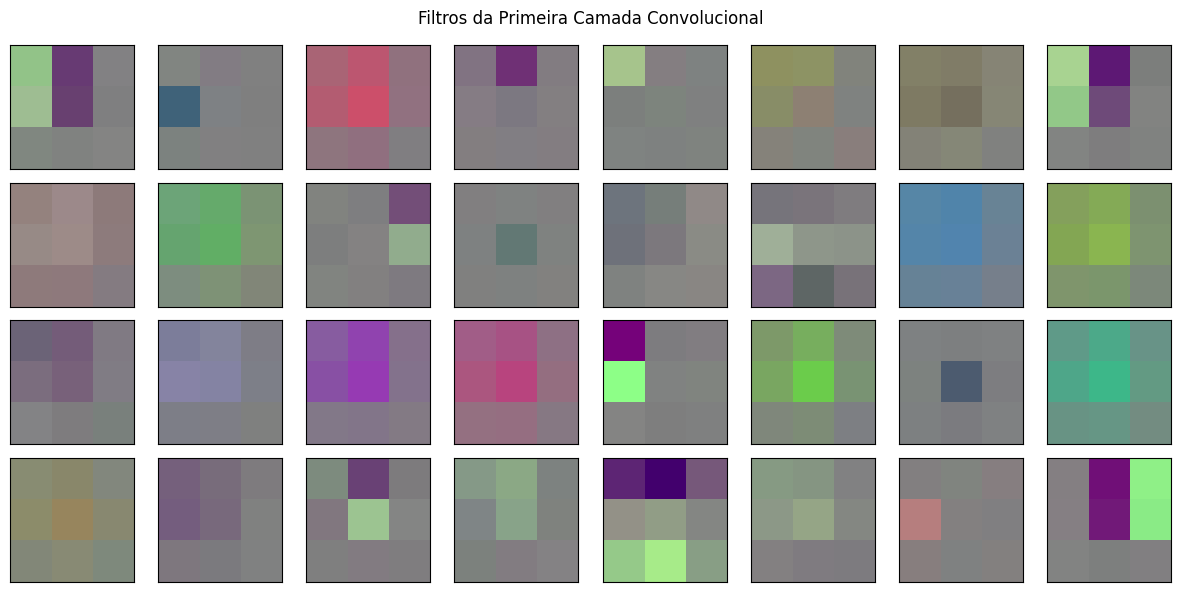


--- Visualizando Ativações Intermediárias ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


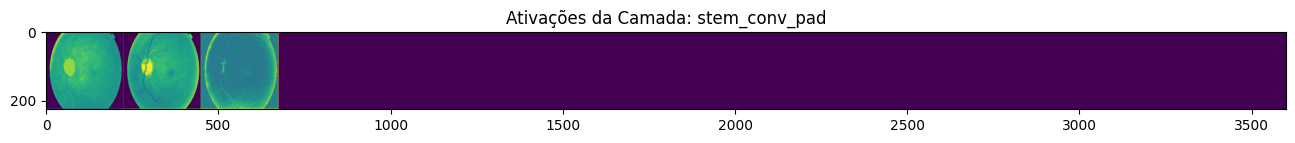

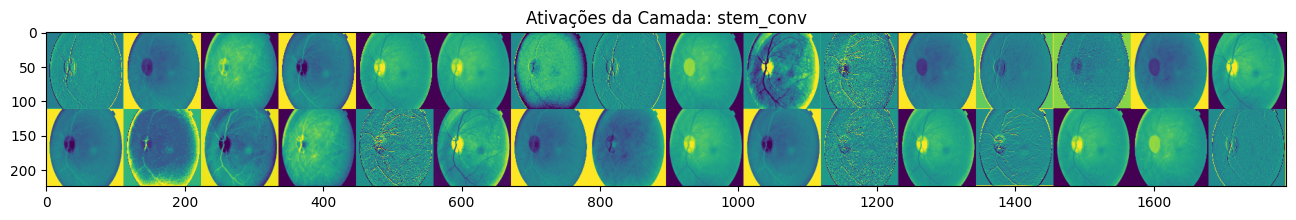

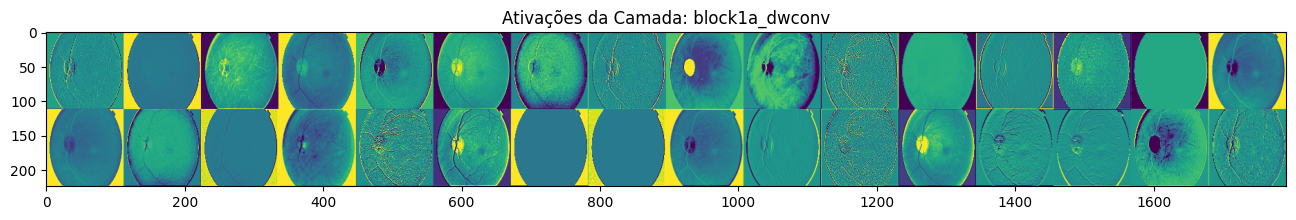

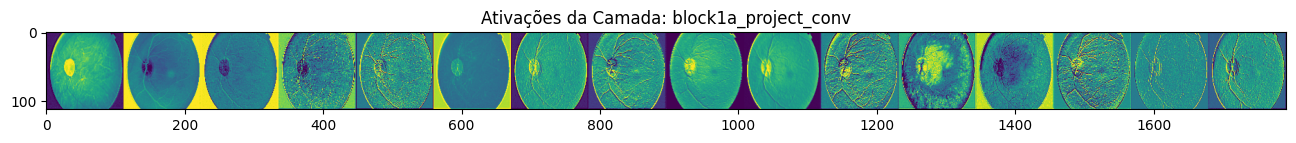

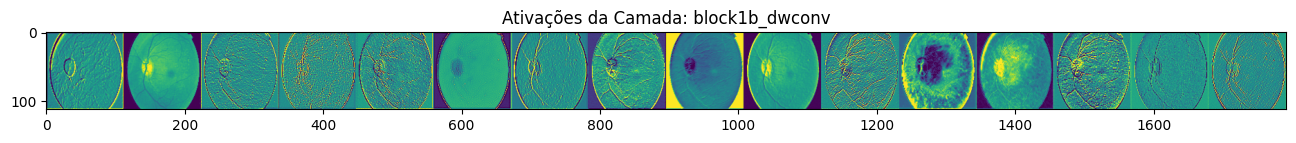

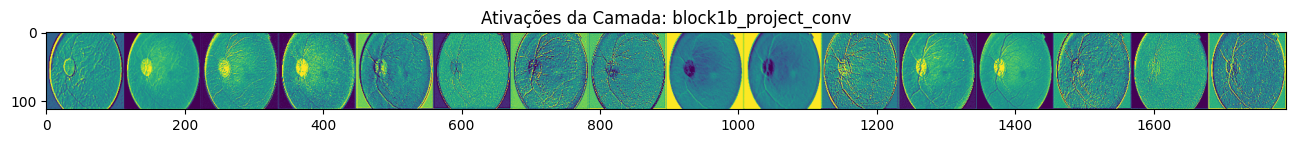

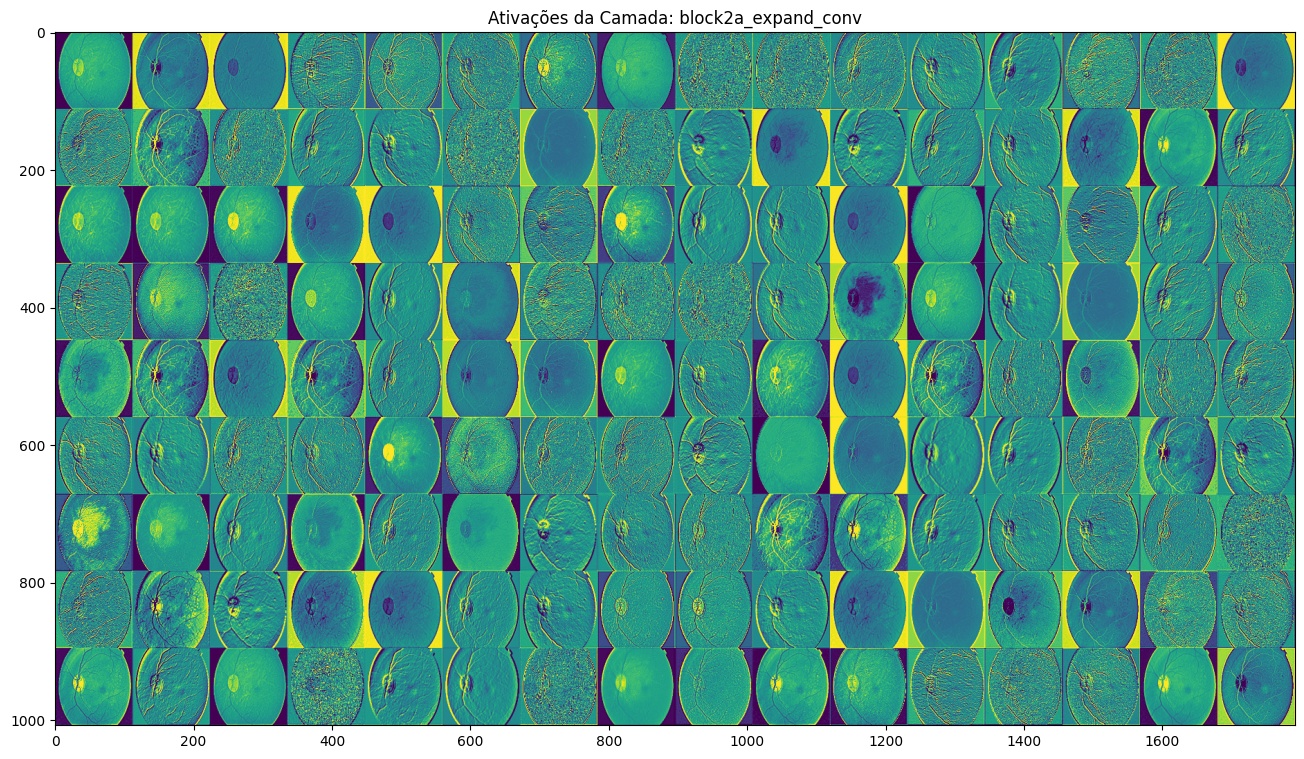

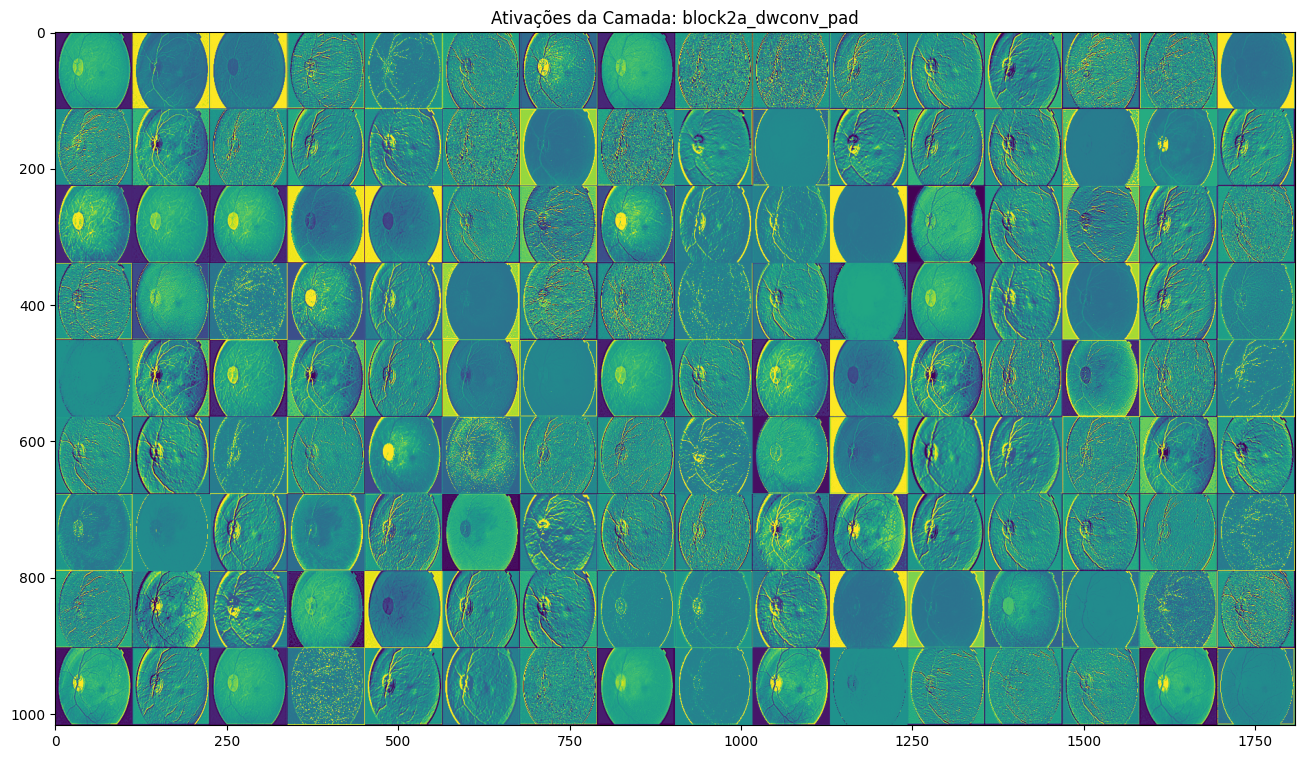


--- Gerando Grad-CAM para a camada: top_conv ---


c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_6']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


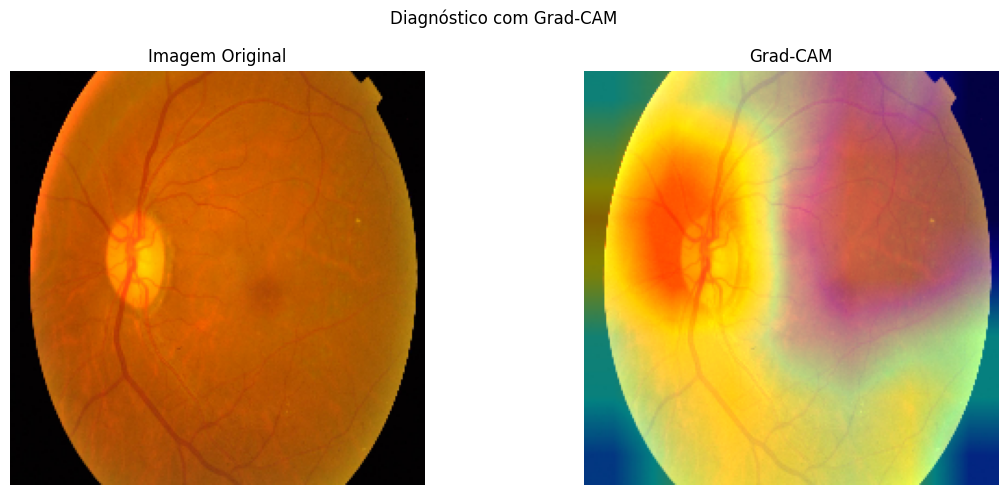

In [8]:
# --- FUNÇÃO 1: VISUALIZAÇÃO DOS FILTROS (PRIMEIRA CAMADA CONV) ---
# --- FUNÇÃO 1 CORRIGIDA: VISUALIZAÇÃO DOS FILTROS ---
def visualize_filters(model):
    """Extrai e plota os filtros da primeira camada convolucional."""
    print("\n--- Visualizando Filtros da Primeira Camada ---")
    
    first_conv_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            first_conv_layer = layer
            break
    
    if not first_conv_layer:
        print("Nenhuma camada Conv2D encontrada no modelo.")
        return

    # --- LINHA CORRIGIDA ---
    # Acessamos apenas o primeiro (e único) elemento da lista retornada por get_weights()
    filters = first_conv_layer.get_weights()[0]
    
    # Normaliza os filtros para o intervalo [0, 1] para visualização
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # O restante do código permanece o mesmo...
    n_filters = min(filters.shape[3], 32)
    n_cols = 8
    n_rows = n_filters // n_cols if n_filters % n_cols == 0 else (n_filters // n_cols) + 1
    
    fig = plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_filters):
        f = filters[:, :, :, i]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        # Para filtros de 3 canais (RGB), podemos visualizar como uma imagem colorida
        if f.shape[-1] == 3:
            ax.imshow(f)
        else: # Ou em tons de cinza se for 1 canal
            ax.imshow(f[:, :, 0], cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle("Filtros da Primeira Camada Convolucional")
    plt.tight_layout()
    plt.show()



# --- FUNÇÃO 2: VISUALIZAÇÃO DAS ATIVAÇÕES INTERMEDIÁRIAS ---
def visualize_activations(model, img_array):
    """Cria um modelo para extrair e plotar os mapas de ativação."""
    print("\n--- Visualizando Ativações Intermediárias ---")

    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name][:8] # Limita às 8 primeiras para não poluir
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name][:8]

    if not layer_outputs:
        print("Nenhuma camada convolucional ou de pooling para visualizar.")
        return

    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_array)
    
    for layer_name, layer_activation in zip(layer_names, activations):
        if len(layer_activation.shape) != 4: continue

        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        
        images_per_row = 16
        n_cols = max(n_features // images_per_row, 1)
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                feature_index = col * images_per_row + row
                if feature_index >= n_features: continue
                channel_image = layer_activation[0, :, :, feature_index]
                channel_image -= channel_image.mean()
                channel_image /= (channel_image.std() + 1e-5)
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
                             
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(f"Ativações da Camada: {layer_name}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# --- FUNÇÃO 3: APLICAÇÃO DE GRAD-CAM ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-9)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img_rgb)
    ax1.set_title("Imagem Original")
    ax1.axis('off')
    
    ax2.imshow(superimposed_img)
    ax2.set_title("Grad-CAM")
    ax2.axis('off')
    
    plt.suptitle("Diagnóstico com Grad-CAM")
    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO DAS ANÁLISES ---
print("\n--- INICIANDO ANÁLISES DO MODELO ---")

# 1. Visualizar Filtros
visualize_filters(model)

# 2. Visualizar Ativações
visualize_activations(model, img_array)

# 3. Gerar Grad-CAM
# IMPORTANTE: Verifique o nome da última camada convolucional no `model.summary()`
# Para EfficientNetB3, geralmente é 'top_conv'
last_conv_layer_name = 'top_conv' 
print(f"\n--- Gerando Grad-CAM para a camada: {last_conv_layer_name} ---")
try:
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam(IMAGE_PATH, heatmap)
except Exception as e:
    print(f"Erro ao gerar Grad-CAM. Verifique se o nome da camada '{last_conv_layer_name}' está correto.")
    print(f"Erro: {e}\n\nLembre-se de verificar o nome correto da última camada convolucional no sumário do modelo.")

## Exibindo arquitetura do modelo

In [ ]:
# import tensorflow as tf
# import visualkeras
# from PIL import ImageFont # Necessário para customizar fontes

# # Carregar o seu modelo salvo
# try:
#     MODEL_PATH = '../efficientnetb3/head/b3-head-564322.keras'
#     model = tf.keras.models.load_model(MODEL_PATH)
#     print(f"Modelo {model} carregado com sucesso!")

#     # Gerar a imagem de visualização em camadas
#     # Você pode customizar fontes, cores e espaçamento
#     visualkeras.layered_view(
#         model,
#         to_file='arquitetura_visual.png', # Salva a imagem
#         legend=True # Adiciona uma legenda explicando as cores das camadas
#     ).show() # Opcional: mostra a imagem na tela ao executar

#     print("Imagem da arquitetura visual salva como 'arquitetura_visual.png'")

# except Exception as e:
#     print(f"Erro ao gerar a visualização: {e}")
#     print("Verifique se o model foi carregado e se a biblioteca 'visualkeras' está instalada.")

Modelo <Functional name=functional_6, built=True> carregado com sucesso!


c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Imagem da arquitetura visual salva como 'arquitetura_visual.png'


Etapas necessárias para o retreino com logs

In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import datetime


In [25]:
MODEL_PATH = '../efficientnetb3/head/b3-head-564322.keras'
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

In [27]:
train_labels_df = pd.read_csv("base_dados/train.csv")
train_labels_df["id_code"] = train_labels_df["id_code"].astype(str) + ".png"
train_labels_df["diagnosis"] = train_labels_df["diagnosis"].astype(str) 

# Gerador de imagens com pré-processamento
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory='base_dados/train_images',
    x_col="id_code",
    y_col="diagnosis",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory='base_dados/train_images',
    x_col="id_code",
    y_col="diagnosis",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    seed=42
)


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [28]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",  
    metrics=["accuracy"]
)


In [30]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # poucas épocas só para gerar log
    callbacks=[tensorboard_callback]
)


c:\Users\danie\anaconda3\envs\trabalho_ia\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 718s 8s/step - accuracy: 0.4586 - loss: 1.3946 - val_accuracy: 0.4604 - val_loss: 1.3183
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 592s 6s/step - accuracy: 0.4712 - loss: 1.3487 - val_accuracy: 0.4604 - val_loss: 1.3133
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1486s 16s/step - accuracy: 0.4570 - loss: 1.3650 - val_accuracy: 0.4604 - val_loss: 1.3423
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 628s 7s/step - accuracy: 0.4617 - loss: 1.3731 - val_accuracy: 0.4604 - val_loss: 1.3083
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 763s 8s/step - accuracy: 0.4822 - loss: 1.3219 - val_accuracy: 0.4604 - val_loss: 1.3051
